
### Simple EDA & Preprocessing

Let's have a look at the dataset. The dataset contains heroes and comics, and the relationship between them. The dataset is divided into three files:

- **nodes.csv:** Contains two columns (node, type), indicating the name and the type (comic, hero) of the nodes.
- **edges.csv:** Contains two columns (hero, comic), indicating in which comics the heroes appear.
- **hero-network.csv:** Contains the network of heroes which appear together in the comics. This file was originally taken from 

What about the data?

In all the files, ther hero names are only 20 characters. All names higher than 20, are truncated. Furthermore, some heroes have the symbol "/" after their name. That should be  their secret identity. Considering that there are a lot of heroes, let's select the most known. We are going to choose the first 50, depending on the number of comics they appear

In [1]:
import pandas as pd
import os
from pathlib import Path
import networkx as nx
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [3]:
# list of heroes, without repetitions

# Read the CSV file
# nodes_data = pd.read_csv("dataset/nodes.csv")
edges_data = pd.read_csv("dataset/edges.csv")
heroes_network_data = pd.read_csv("dataset/hero-network.csv")

### Retrieveing the most famous heroes

We define the most famous hero as the one that appears in more comics.

The edge_data dataset contains in which comic an hero appeares. So, let's count the number of appearances of each hero, in order to understand who are the more famous.

In [37]:
# Count the appearances of each hero
hero_counts = edges_data['hero'].value_counts()
hero_counts

hero
SPIDER-MAN/PETER PARKER    1577
CAPTAIN AMERICA            1334
IRON MAN/TONY STARK        1150
THING/BENJAMIN J. GR        963
THOR/DR. DONALD BLAK        956
                           ... 
PROGENITOR                    1
DOMANI, DINO                  1
DOGGEREL                      1
DOCTOR, DR. JOSHUA            1
24-HOUR MAN/EMMANUEL          1
Name: count, Length: 6439, dtype: int64

Select the first 25 most famous heroes, according to the rank printed above.

In [5]:
hero_selection_number = 25

# Extract the first 25 hero names
heroes = hero_counts.head(hero_selection_number).index.tolist()

# Display the first 25 heroes
print(heroes)

['SPIDER-MAN/PETER PARKER', 'CAPTAIN AMERICA', 'IRON MAN/TONY STARK', 'THING/BENJAMIN J. GR', 'THOR/DR. DONALD BLAK', 'HUMAN TORCH/JOHNNY S', 'MR. FANTASTIC/REED R', 'HULK/DR. ROBERT BRUC', 'WOLVERINE/LOGAN', 'INVISIBLE WOMAN/SUE', 'SCARLET WITCH/WANDA', 'BEAST/HENRY &HANK& P', 'DR. STRANGE/STEPHEN', 'WATSON-PARKER, MARY', 'DAREDEVIL/MATT MURDO', 'HAWK', 'VISION', 'CYCLOPS/SCOTT SUMMER', 'WASP/JANET VAN DYNE', 'JAMESON, J. JONAH', 'ANT-MAN/DR. HENRY J.', 'SUB-MARINER/NAMOR MA', 'STORM/ORORO MUNROE S', 'PROFESSOR X/CHARLES', 'FURY, COL. NICHOLAS']


in hero-network.csv file, ther hero names are only 20 characters or lower. All names higher than 20, are truncated. Furthermore, some heroes have the symbol "/" after their name. The right part after the "/" should be their secret identity. Let's truncate the heros' name in heroes list, according to the dataset file, and let's remove the secret identity of a hero. We do the same also with heroes_network dataset

In [6]:
heroes = [heroes[i][:20].split('/')[0] for i in range(len(heroes))]
for c in ['hero1', 'hero2']:
    heroes_network_data[c] = heroes_network_data[c].apply(lambda x : x[:20].split("/")[0])

# print(heroes)
# heroes_network_data

We are going to create a new dataset, with the purpose of reporting all the appearance  of two heroes together. The new dataset is composed by three columns, and every hero is combined with all the others. The total number of heroes combined each other is 25, the 25 most known heroes selected before:

- **Hero1:** name of hero 1;
- **Hero2:** name of hero 2;
- **Appeared_Together:** Number of times they appeared together.

In [7]:
file = './backups/network_df.csv'
# Ff the backup file exists, read it as pandas dataframe
if os.path.exists(file):
    network_df = pd.read_csv(file)
else:
    # the backup file does not exist. Let's create the dataset combining all the heroes
    list_heroes_1 = []
    list_heroes_2 = []
    list_appear_together = []

    for i in range(len(heroes)):
        for j in range(i+1, len(heroes)):
            list_heroes_1.append(heroes[i])
            list_heroes_2.append(heroes[j])
            # counting af appearances of the two heroes, also switching the order where they are written
            appear_together = len(heroes_network_data[(heroes_network_data['hero1']==heroes[i])&(heroes_network_data['hero2']==heroes[j])])
            appear_together += len(heroes_network_data[(heroes_network_data['hero1']==heroes[j])&(heroes_network_data['hero2']==heroes[i])])
            list_appear_together.append(appear_together)
    # new dataframe creation
    network_df = pd.DataFrame({'Hero1':list_heroes_1, 'Hero2':list_heroes_2, 'Appeared_Together':list_appear_together})

    # Dataset storage into a file, in order to speed up the process during the next execution
    filepath = Path(file)  
    network_df.to_csv(filepath, index=False)  

display(network_df.head())

,Hero1,Hero2,Appeared_Together
0,SPIDER-MAN,CAPTAIN AMERICA,145
1,SPIDER-MAN,IRON MAN,94
2,SPIDER-MAN,THING,126
3,SPIDER-MAN,THOR,95
4,SPIDER-MAN,HUMAN TORCH,147


Sorting the heroes relation in descending order, based on the *Appeared_Together* value

In [8]:
network_df = network_df.sort_values('Appeared_Together', ascending=False)
display(network_df)

,Hero1,Hero2,Appeared_Together
70,THING,HUMAN TORCH,744
110,HUMAN TORCH,MR. FANTASTIC,713
71,THING,MR. FANTASTIC,708
131,MR. FANTASTIC,INVISIBLE WOMAN,701
113,HUMAN TORCH,INVISIBLE WOMAN,694
...,...,...,...
60,IRON MAN,VISION,0
213,BEAST,VISION,0
68,IRON MAN,"FURY, COL. NICHOLAS",0
210,BEAST,"WATSON-PARKER, MARY",0


# Network & Centrality

### Network/Graph creation

Indirect graph, according to the following schema:
- **Nodes:** heroes.
- **Edges:** appearance of two heroes in the same comic. The edge will be weighted depending on the number of appearances.

As we can notice by the dataset representation above, there are some heroes that never appeared together. In those cases, there won't be any edge. As a consequence, if a hero is not linked to any of the others, it will not be inserted into the graph.

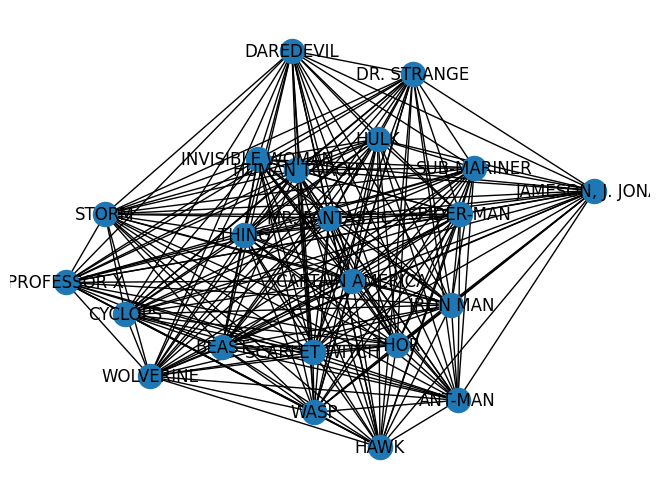

In [9]:
# Graph creation
G = nx.Graph()

for hero1, hero2, weight in network_df.values.tolist():
    # Checking if the weight (number of appearances) is not 0
    if int(weight) != 0:
        G.add_edge(hero1, hero2, weight=weight)

# Graph representation
nx.draw(G, with_labels=True)
plt.show()

Graph formatting, in order to make it more readable. Operations executed:
- enlarged output image;
- normalized edges weights and multiplied that by a constant scaling factor;
- chose the spring layout
- set nodes, edges and labels configuration

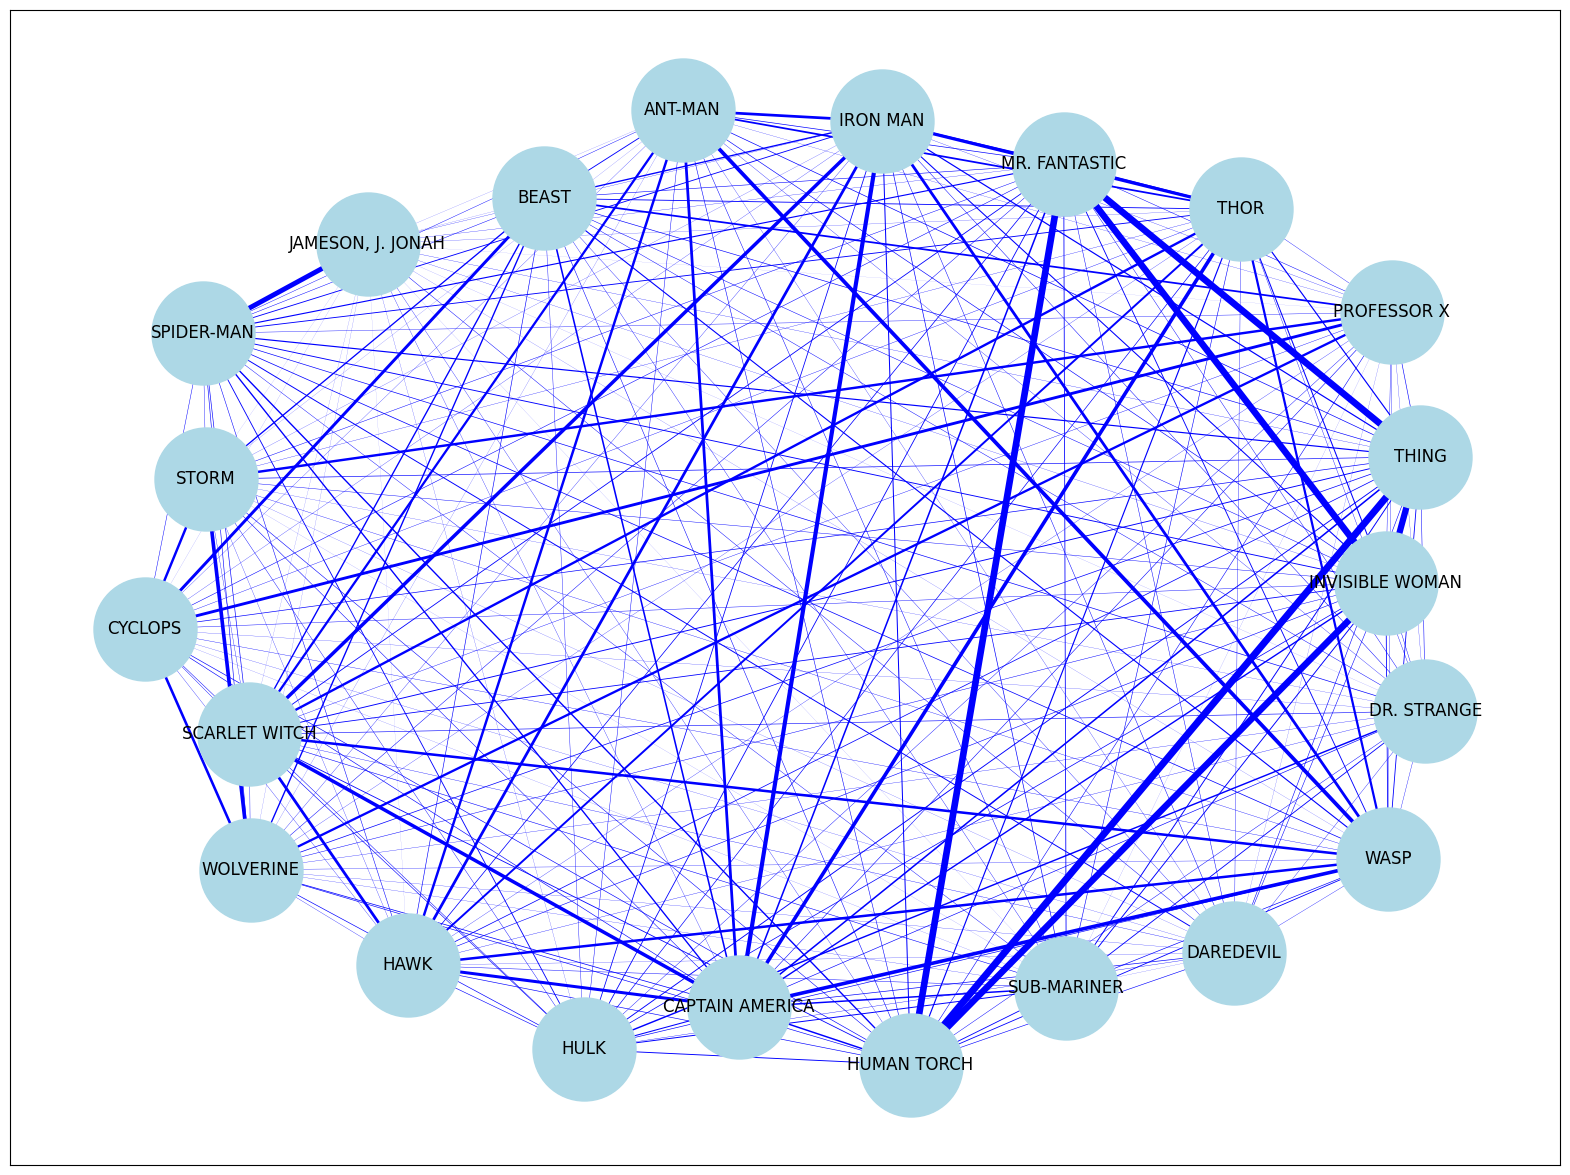

In [10]:
# Drawing the graph with varying edge widths, bigger nodes, and wider final image

# Enlarging image
rcParams['figure.figsize'] = 20, 15

# Getting the edges' max ewight, useful for weight normalization
max_weight = max([G[u][v]['weight'] for u, v in G.edges()])
# Get the weight values from the edge attributes, normalized by the max weight
edge_widths = [G[u][v]['weight']/max_weight for u, v in G.edges()]
# Set a scaling factor to enhance line thickness
scaling_factor = 5
# Multiply the edge widths by the scaling factor
enhanced_edge_widths = [width * scaling_factor for width in edge_widths]

# Layout settings
layout = nx.spring_layout(G, k=100)

# Nodes representation
nx.draw_networkx_nodes(G, layout, node_color='lightblue', node_size=5500)
# Edges representation
nx.draw_networkx_edges(G, layout, width=enhanced_edge_widths, edge_color='blue')
# Labels representation
nx.draw_networkx_labels(G, layout)

plt.show()

### Centrality & Analysis

Centrality is a concept in network analysis that measures the importance, influence, or prominence of nodes (vertices) within a network. It provides a way to quantify and rank nodes based on their relative position and connectivity in the network.

Let's compute now the centrality, according to several measures.     

1. **Weighted Degree Centrality:**
    Degree centrality measures the number of connections a node has in a network.
    Weighted degree centrality takes into account the weights of the edges in a network, giving more importance to nodes with 
    higher-weighted connections. It quantifies the centrality of a node based on the sum of the weights of its incident edges.
    Higher weighted degree centrality indicates that a node is more central in terms of the overall weight of its connections.

2. **Betweenness Centrality:**
    Betweenness centrality measures the extent to which a node lies on the shortest paths between pairs of other nodes.
    It quantifies the importance of a node in facilitating the flow of information or resources between other nodes.
    Nodes with high betweenness centrality act as bridges or brokers between different parts of the network.
    They have the potential to control or influence the flow of information or resources in the network.

3. **Closeness Centrality:**
    Closeness centrality measures how quickly a node can reach all other nodes in the network.
    It quantifies the average distance of a node to all other nodes in terms of shortest paths.
    Nodes with high closeness centrality are more central because they can quickly access or disseminate information to other nodes in the network.
    Closeness centrality is inversely related to the average distance or path length to other nodes.

4. **PageRank Centrality:**
    PageRank centrality measures the importance of a node in a network based on the concept of "random walk."
    It originated from Google's PageRank algorithm, which ranks web pages based on their importance on the internet.
    Nodes with high PageRank centrality are those that are frequently visited or reached by random walks on the network.
    It considers both the direct and indirect connections of a node, giving higher importance to nodes with incoming links from other important nodes.

5. **Eigenvector Centrality:**
        Eigenvector centrality assigns a score to each node based on the concept of eigenvectors.
        It considers both the number of connections a node has and the importance of those connections.
        Nodes connected to other important nodes receive a higher eigenvector centrality score.
        Eigenvector centrality measures the influence or importance of a node in the network based on the centrality of its neighboring nodes.

These measures provide different perspectives on the centrality, influence, and connectivity of nodes within a social network. Each measure offers insights into different aspects of node importance.

Weighted degree Centrality computation

In [11]:
##################################################################
#################### Weighted Degree Centrality ##################
##################################################################
# The output is a dictionary-format: the key is the hero's name, and the value represents the degree centrality
degree_centrality = nx.degree(G, weight='weight')
# centrality values extraction
degree_centrality = list(dict(degree_centrality).values())


##################################################################
#################### Betweenness Centrality ######################
##################################################################
# The output is a dictionary-format: the key is the hero's name, and the value represents the betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G, weight='weight')
# centrality values extraction
betweenness_centrality = list(dict(betweenness_centrality).values())


##################################################################
##################### Closeness Centrality #######################
##################################################################
'''
In order to determine it, we need to compute the "distance" parameter. 
Considering that the weight of each edge is the number of times two heroes 
appeared together, we can assetrt that the higher the weight, the lower 
the distance between two edges. So, the distance is inversely proportional 
to weight. As a consequence, we are going to compute the distance between 
two nodes as 1 / the weight of the edge.
'''
g_distance_dict = {(e1, e2): 1 / weight for e1, e2, weight in G.edges(data='weight')}
nx.set_edge_attributes(G, g_distance_dict, 'distance')
# The output is a dictionary-format: the key is the hero's name, and the value represents the closeness centrality
closeness_centrality = nx.closeness_centrality(G, distance='distance')
# centrality values extraction
closeness_centrality = list(dict(closeness_centrality).values())


##################################################################
##################### Pagerank Centrality ########################
##################################################################
# The output is a dictionary-format: the key is the hero's name, and the value represents the pagerank centrality
pagerank_centrality = nx.pagerank(G, weight='weight')
# centrality values extraction
pagerank_centrality = list(dict(pagerank_centrality).values())


##################################################################
##################### Eigenvector Centrality #####################
##################################################################
# The output is a dictionary-format: the key is the hero's name, and the value represents the eigenvector centrality
eigenvector_centrality = nx.eigenvector_centrality(G, weight='weight')
# centrality values extraction
eigenvector_centrality = list(dict(eigenvector_centrality).values())

# tabular representation of the centrality values just computed
all_centrality = pd.DataFrame({
    'Weighted Degree':degree_centrality, 
    'Betweenness':betweenness_centrality, 
    'Closeness':closeness_centrality, 
    'Pagerank':pagerank_centrality, 
    'Eigenvector':eigenvector_centrality
}, index=list(G.nodes))

all_centrality

,Weighted Degree,Betweenness,Closeness,Pagerank,Eigenvector
THING,3702,0.000000,104.155292,0.066598,0.364029
HUMAN TORCH,3643,0.000000,101.499983,0.065592,0.362085
MR. FANTASTIC,3580,0.000000,99.059541,0.064361,0.360318
INVISIBLE WOMAN,3387,0.000000,96.093903,0.061179,0.346927
SPIDER-MAN,2160,0.000000,92.521401,0.045262,0.142312
"JAMESON, J. JONAH",921,0.838095,79.246082,0.022867,0.057757
CAPTAIN AMERICA,3863,0.000000,136.829520,0.070749,0.293444
IRON MAN,3163,0.000000,115.488804,0.058660,0.252594
WASP,2807,0.000000,107.519309,0.052817,0.221972
ANT-MAN,2364,0.000000,99.905870,0.045326,0.191405


Since all the heroes are linked together, using Betweenness Centrality, which accounts for the shortest path between all pairs, is not appropriate; we are going to drop that column

In [12]:
# Drop the 'Betweenness' column
all_centrality = all_centrality.drop('Betweenness', axis=1)
all_centrality

,Weighted Degree,Closeness,Pagerank,Eigenvector
THING,3702,104.155292,0.066598,0.364029
HUMAN TORCH,3643,101.499983,0.065592,0.362085
MR. FANTASTIC,3580,99.059541,0.064361,0.360318
INVISIBLE WOMAN,3387,96.093903,0.061179,0.346927
SPIDER-MAN,2160,92.521401,0.045262,0.142312
"JAMESON, J. JONAH",921,79.246082,0.022867,0.057757
CAPTAIN AMERICA,3863,136.829520,0.070749,0.293444
IRON MAN,3163,115.488804,0.058660,0.252594
WASP,2807,107.519309,0.052817,0.221972
ANT-MAN,2364,99.905870,0.045326,0.191405


Subplotting of all the centralities. Barplot has been chosen

/tmp/ipykernel_20943/1796011578.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0, 0].set_xticklabels(list(G.nodes), rotation='vertical')
/tmp/ipykernel_20943/1796011578.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0, 1].set_xticklabels(list(G.nodes), rotation='vertical')
/tmp/ipykernel_20943/1796011578.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, 0].set_xticklabels(list(G.nodes), rotation='vertical')
/tmp/ipykernel_20943/1796011578.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, 1].set_xticklabels(list(G.nodes), rotation='vertical')


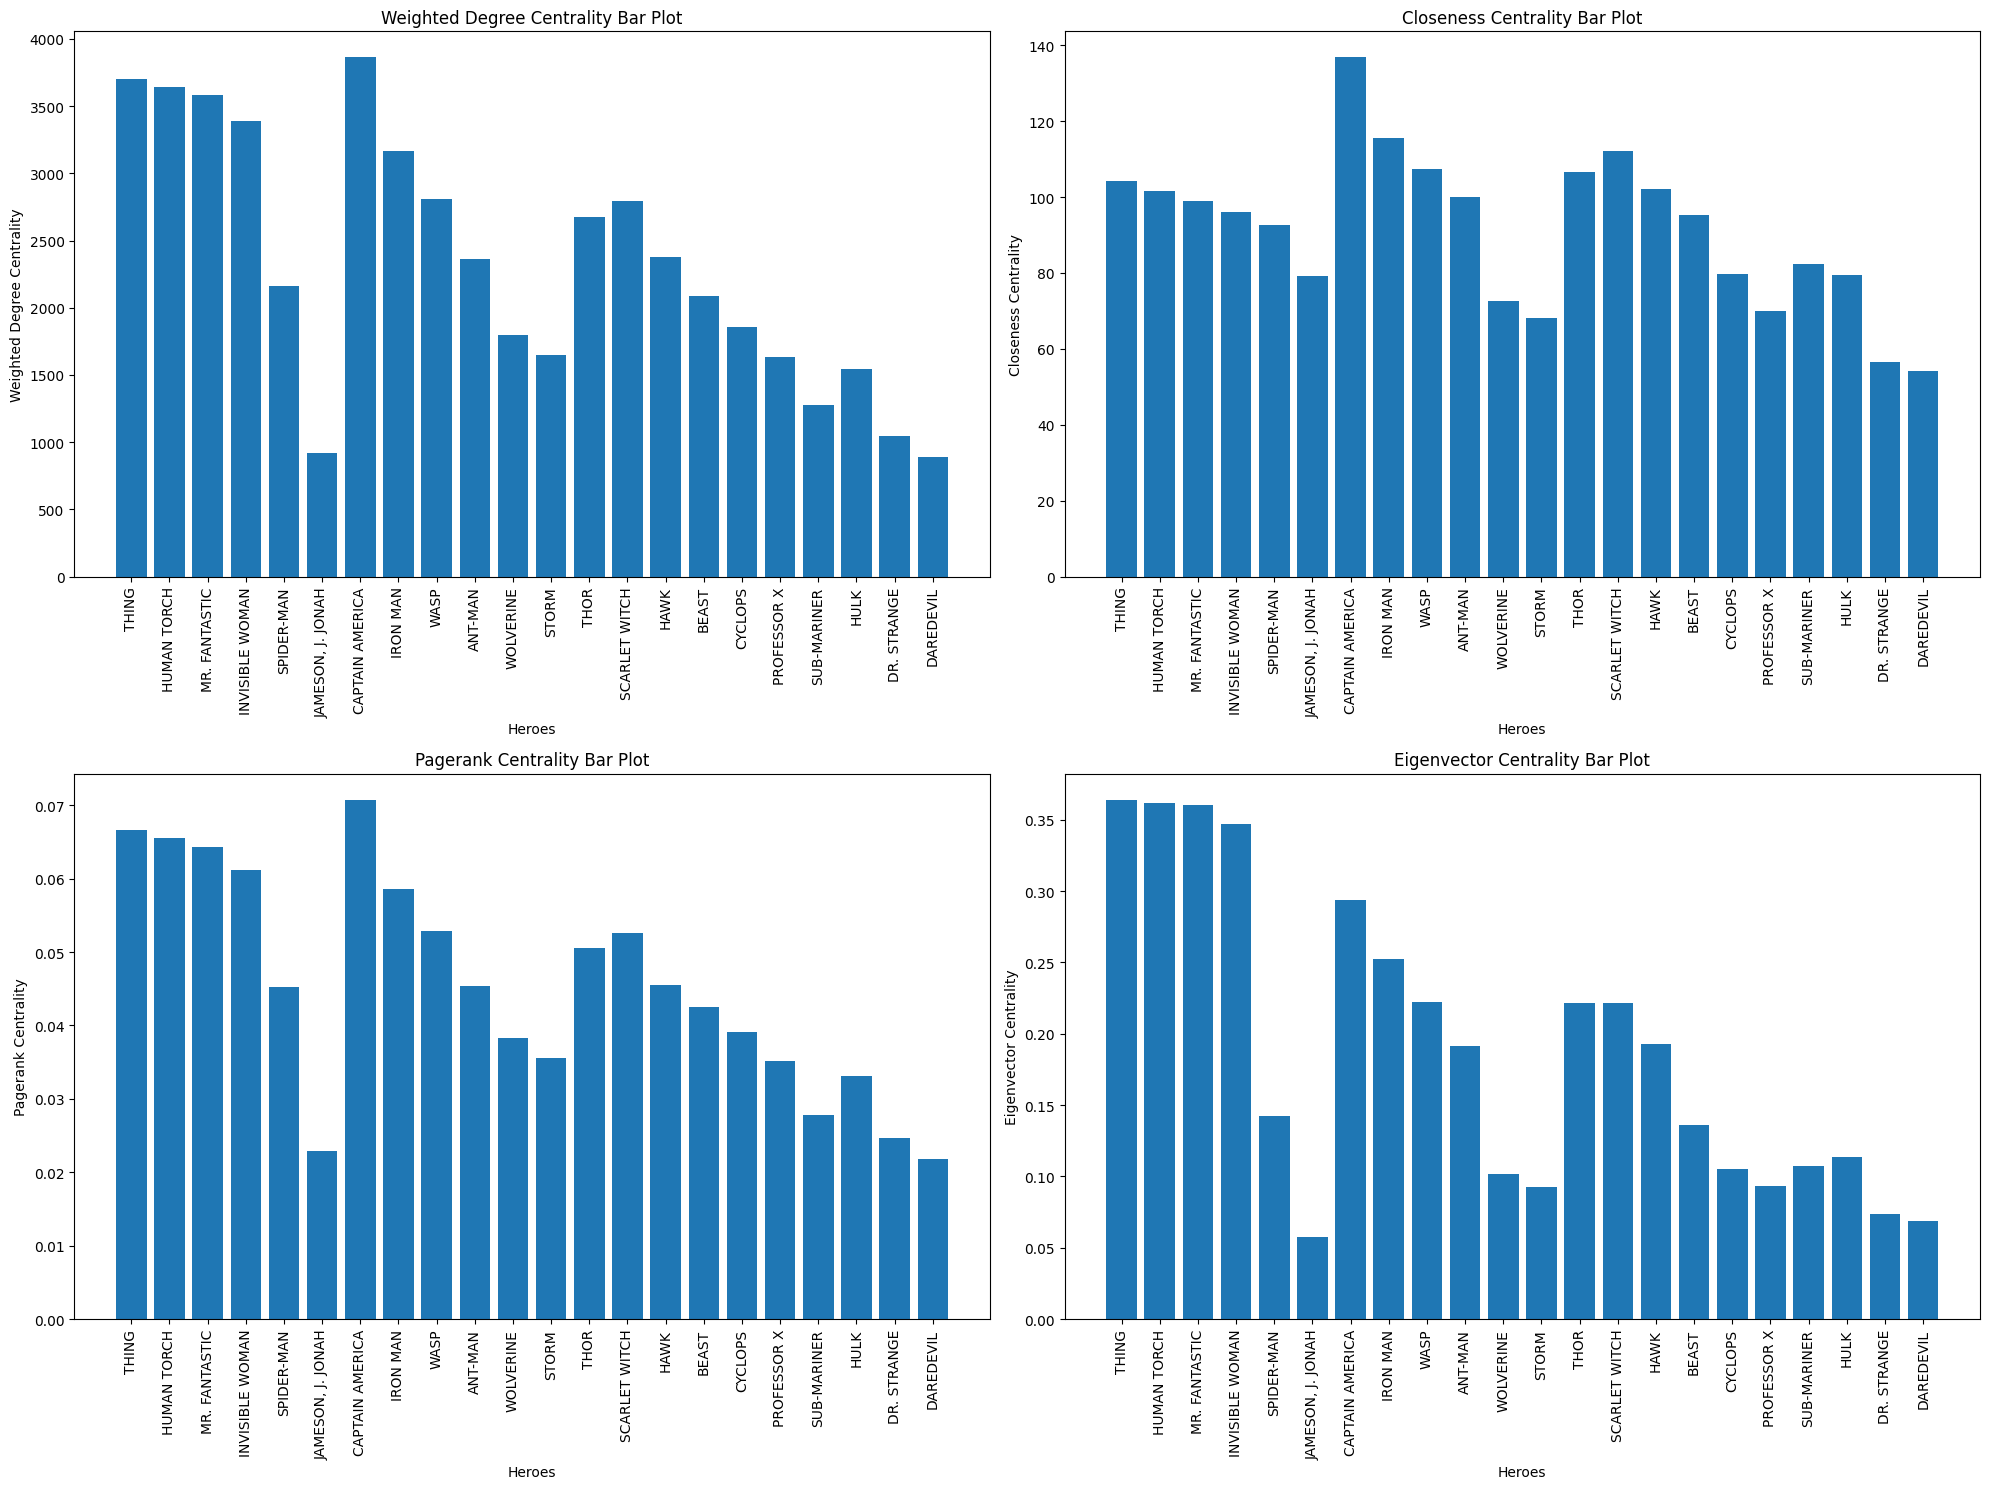

In [13]:
# Create a figure with four subplots
fig, axes = plt.subplots(nrows=2, ncols=2)

###################################################
########## Plot the data in each subplot ##########
###################################################

# plotting Weighted Degree Centrality
axes[0, 0].bar(list(G.nodes), all_centrality['Weighted Degree'])
# set the y labels
axes[0, 0].set_xlabel('Heroes')
# set the y labels
axes[0, 0].set_ylabel('Weighted Degree Centrality')
# set the subplot title
axes[0, 0].set_title('Weighted Degree Centrality Bar Plot')
# Rotate x-axis labels vertically
axes[0, 0].set_xticklabels(list(G.nodes), rotation='vertical')


# plotting Closeness Centrality
axes[0, 1].bar(list(G.nodes), all_centrality['Closeness'])
# set the y labels
axes[0, 1].set_xlabel('Heroes')
# set the y labels
axes[0, 1].set_ylabel('Closeness Centrality')
# set the subplot title
axes[0, 1].set_title('Closeness Centrality Bar Plot')
# Rotate x-axis labels vertically
axes[0, 1].set_xticklabels(list(G.nodes), rotation='vertical')


# plotting Pagerank Centrality
axes[1, 0].bar(list(G.nodes), all_centrality['Pagerank'])
# set the y labels
axes[1, 0].set_xlabel('Heroes')
# set the y labels
axes[1, 0].set_ylabel('Pagerank Centrality')
# set the subplot title
axes[1, 0].set_title('Pagerank Centrality Bar Plot')
# Rotate x-axis labels vertically
axes[1, 0].set_xticklabels(list(G.nodes), rotation='vertical')

# plotting Eigenvector Centrality
axes[1, 1].bar(list(G.nodes), all_centrality['Eigenvector'])
# set the y labels
axes[1, 1].set_xlabel('Heroes')
# set the y labels
axes[1, 1].set_ylabel('Eigenvector Centrality')
# set the subplot title
axes[1, 1].set_title('Eigenvector Centrality Bar Plot')
# Rotate x-axis labels vertically
axes[1, 1].set_xticklabels(list(G.nodes), rotation='vertical')


# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

As we can easily see, every measure has its own most important heroes. In order to understand who is the most important hero according to all the measures provided above, we are going to compute the mean of all the centrality values for each hero. Of course, we face an important problem: every centrality measure has a different scale. In order to standardize the values and ensuring fair comparisons, we are going to use MinMaxScaler technique.

In [15]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler to the data and transform the data
scaled_data = scaler.fit_transform(all_centrality)

# Create a new DataFrame with the scaled data
scaled_centrality = pd.DataFrame(scaled_data, columns=all_centrality.columns, index=list(G.nodes))
scaled_centrality

,Weighted Degree,Closeness,Pagerank,Eigenvector
THING,0.945791,0.605164,0.915083,1.000000
HUMAN TORCH,0.925926,0.573077,0.894510,0.993651
MR. FANTASTIC,0.904714,0.543586,0.869341,0.987882
INVISIBLE WOMAN,0.839731,0.507750,0.804240,0.944161
SPIDER-MAN,0.426599,0.464579,0.478657,0.276077
"JAMESON, J. JONAH",0.009428,0.304160,0.020575,0.000000
CAPTAIN AMERICA,1.000000,1.000000,1.000000,0.769533
IRON MAN,0.764310,0.742118,0.752717,0.636154
WASP,0.644444,0.645815,0.633193,0.536174
ANT-MAN,0.495286,0.553814,0.479979,0.436369


Now that we transformed the data into the same scale, we can proceed by applying the centrality mean computation, hero by hero. Then, that mean (called from now General Centrality) is plotted in a bar plot.

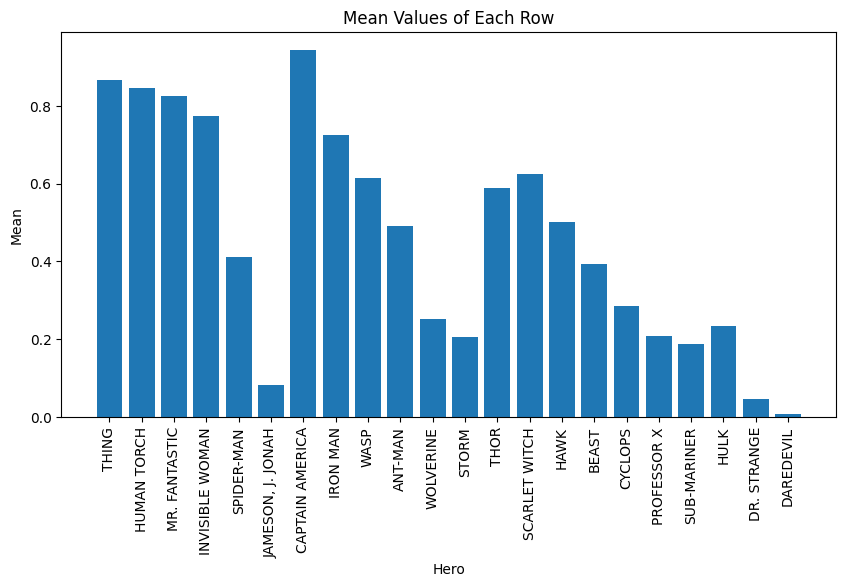

In [34]:
# Compute the mean of each row
row_means = scaled_centrality.mean(axis=1)

# Resize the plot
plt.figure(figsize=(10, 5)) 
plt.bar(scaled_centrality.index, row_means)
plt.xlabel('Hero')
plt.ylabel('Mean')
plt.title('Mean Values of Each Row')
# Rotate x-axis labels vertically
plt.xticks(rotation='vertical')
plt.show()

As we can see, Captain America represents the hero with the higher general centrality value. According to these new values, we can change the network plotted before by resizing the nodes depending on their general centrality: the higher the centrality, the wider the node

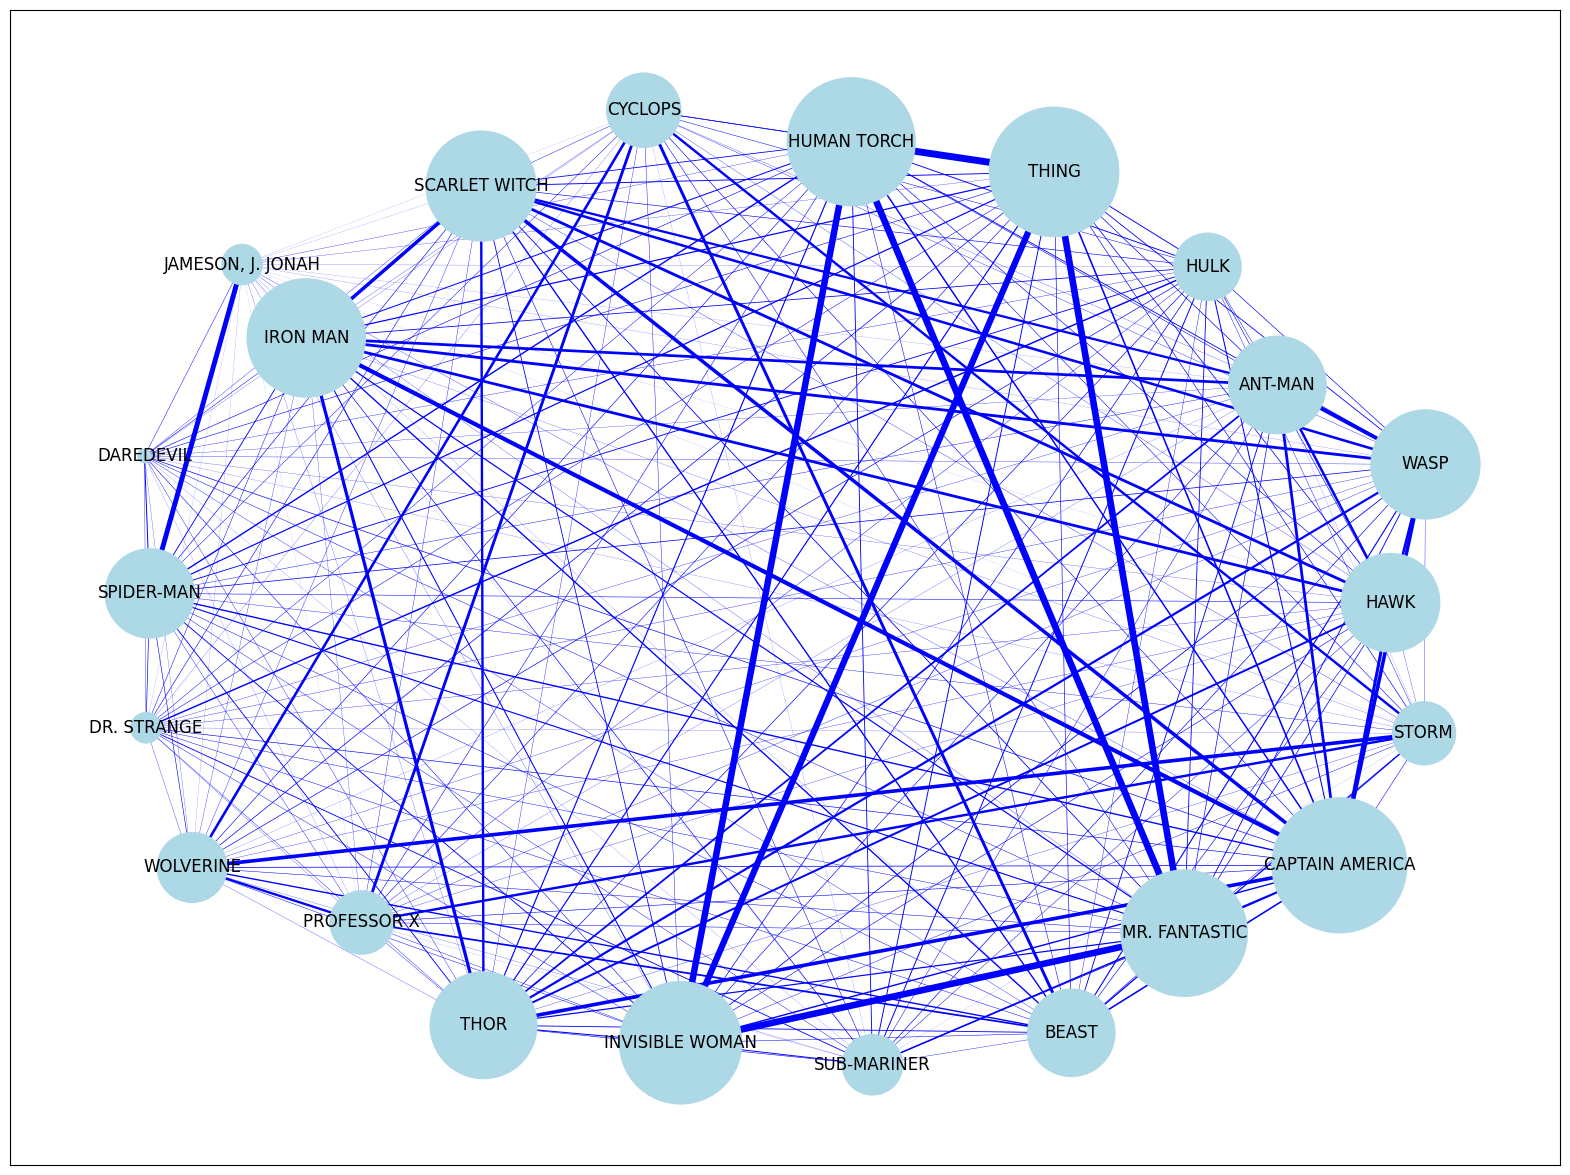

In [35]:
# Drawing the graph with varying edge widths, bigger nodes, and wider final image

# Enlarging image
rcParams['figure.figsize'] = 20, 15

# Getting the edges' max ewight, useful for weight normalization
max_weight = max([G[u][v]['weight'] for u, v in G.edges()])
# Get the weight values from the edge attributes, normalized by the max weight
edge_widths = [G[u][v]['weight']/max_weight for u, v in G.edges()]
# Set a scaling factor to enhance line thickness
scaling_factor = 5
# Multiply the edge widths by the scaling factor
enhanced_edge_widths = [width * scaling_factor for width in edge_widths]

# Layout settings
layout = nx.spring_layout(G, k=100)

# Nodes representation
nx.draw_networkx_nodes(G, layout, node_color='lightblue', node_size=[10000*row_means[i] for i in range(len(row_means))])
# Edges representation
nx.draw_networkx_edges(G, layout, width=enhanced_edge_widths, edge_color='blue')
# Labels representation
nx.draw_networkx_labels(G, layout)

plt.show()

# Who is the most important hero?
![My Image](https://img.ilgcdn.com/sites/default/files/styles/xl/public/foto/2014/02/25/1393314378-capitan-america.jpg?_=1393314378)
